# Predict Customer Personality To Boost Marketing Campaign By Using Machine Learning

# Load Data

In [217]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator, FuncFormatter
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

In [218]:
df = pd.read_csv('marketing_campaign_data.csv')
df.sample(5)

,Unnamed: 0,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,...,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
1999,1999,176,1980,D3,Lajang,67506000.0,0,1,02-01-2014,73,...,3,0,0,0,0,0,0,3,11,0
77,77,7503,1976,S1,Lajang,75825000.0,0,0,12-10-2012,40,...,4,1,0,0,0,0,0,3,11,1
921,921,4483,1993,S1,Lajang,72354000.0,0,0,17-04-2013,67,...,1,0,0,0,0,0,0,3,11,0
1580,1580,3790,1956,S1,Bertunangan,34633000.0,2,1,23-01-2014,31,...,6,0,0,0,0,0,0,3,11,0
1470,1470,9672,1970,D3,Menikah,23162000.0,1,1,21-12-2013,82,...,6,0,0,0,0,0,0,3,11,0


In [219]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2240 entries, 0 to 2239
Data columns (total 30 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Unnamed: 0           2240 non-null   int64  
 1   ID                   2240 non-null   int64  
 2   Year_Birth           2240 non-null   int64  
 3   Education            2240 non-null   object 
 4   Marital_Status       2240 non-null   object 
 5   Income               2216 non-null   float64
 6   Kidhome              2240 non-null   int64  
 7   Teenhome             2240 non-null   int64  
 8   Dt_Customer          2240 non-null   object 
 9   Recency              2240 non-null   int64  
 10  MntCoke              2240 non-null   int64  
 11  MntFruits            2240 non-null   int64  
 12  MntMeatProducts      2240 non-null   int64  
 13  MntFishProducts      2240 non-null   int64  
 14  MntSweetProducts     2240 non-null   int64  
 15  MntGoldProds         2240 non-null   i

# Data Preprocessing

## Check duplicate value

In [220]:
df.duplicated(subset=['ID']).sum()

0

## Handling missing values

In [221]:
# there are 34 row with missing values in income column
# fill missing value with column median in income column
df['Income'] = df['Income'].fillna(df['Income'].median())
df['Income'].isna().sum()

0

## Feature extraction

In [222]:
df['Dt_Customer'] = pd.to_datetime(df['Dt_Customer'])
# The date on which the first and last customer made a transaction
print("The newest customer's enrolment date in data:",max(df['Dt_Customer']))
print("The oldest customer's enrolment date in data:",min(df['Dt_Customer']))

The newest customer's enrolment date in data: 2014-12-06 00:00:00
The oldest customer's enrolment date in data: 2012-01-08 00:00:00


In [223]:
df['CustomerDays'] = (pd.to_datetime("2014-12-07") - df['Dt_Customer']) // np.timedelta64(1,'M')
df['Age'] = 2014 - df['Year_Birth']

# Total Spending
TotalSpent = [col for col in df.columns if 'Mnt' in col]
df['TotalSpent'] = df[TotalSpent].sum(axis=1)

# Total children and is customer parent?
df['TotalChildren'] = df['Kidhome']+df['Teenhome']
df['IsParent']=np.where(df.TotalChildren> 0, 1, 0)

In [224]:
# Total Buying Conversion
TotalPurchase = ['NumDealsPurchases', 'NumWebPurchases', 'NumCatalogPurchases','NumStorePurchases']
df['NumPurchase'] = df[TotalPurchase].sum(axis=1)

# Conversion Rate
df['ConversionRate'] = df['NumPurchase'] / df['NumWebVisitsMonth']
df.ConversionRate.replace([np.inf, -np.inf], 0, inplace=True)

In [225]:
df['ConversionRate'] = df['ConversionRate'].replace(np.nan, 0)

In [226]:
# Total Accepted Campaigns
TotalCampaign = [col for col in df.columns if 'Cmp' in col]
df['TotalCampaign'] = df[TotalCampaign].sum(axis=1)

In [227]:
# check value in categorical columns
print(df['Education'].value_counts(), "\n")
print(df['Marital_Status'].value_counts())

S1     1127
S3      486
S2      370
D3      203
SMA      54
Name: Education, dtype: int64 

Menikah        864
Bertunangan    580
Lajang         484
Cerai          232
Janda           77
Duda             3
Name: Marital_Status, dtype: int64


## Remove redundant features

In [228]:
df_prep = df[['ID', 'Education', 'Marital_Status','Income','Age','TotalChildren','IsParent','Recency','CustomerDays',
             'MntCoke','MntFruits', 'MntMeatProducts','MntFishProducts','MntSweetProducts', 'MntGoldProds',
             'TotalSpent','TotalCampaign','NumPurchase','ConversionRate','Complain','Response',
             'NumDealsPurchases','NumWebPurchases', 'NumCatalogPurchases','NumStorePurchases','NumWebVisitsMonth']]
df_prep.head()

,ID,Education,Marital_Status,Income,Age,TotalChildren,IsParent,Recency,CustomerDays,MntCoke,...,TotalCampaign,NumPurchase,ConversionRate,Complain,Response,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth
0,5524,S1,Lajang,58138000.0,57,0,0,58,31,635000,...,0,25,3.571429,0,1,3,8,10,4,7
1,2174,S1,Lajang,46344000.0,60,2,1,38,4,11000,...,0,6,1.200000,0,0,2,1,1,2,5
2,4141,S1,Bertunangan,71613000.0,49,0,0,26,15,426000,...,0,21,5.250000,0,0,1,8,2,10,4
3,6182,S1,Bertunangan,26646000.0,30,1,1,26,2,11000,...,0,8,1.333333,0,0,2,2,0,4,6
4,5324,S3,Menikah,58293000.0,33,1,1,94,10,173000,...,0,19,3.800000,0,0,5,5,3,6,5


In [229]:
df_prep.columns

Index(['ID', 'Education', 'Marital_Status', 'Income', 'Age', 'TotalChildren',
       'IsParent', 'Recency', 'CustomerDays', 'MntCoke', 'MntFruits',
       'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts',
       'MntGoldProds', 'TotalSpent', 'TotalCampaign', 'NumPurchase',
       'ConversionRate', 'Complain', 'Response', 'NumDealsPurchases',
       'NumWebPurchases', 'NumCatalogPurchases', 'NumStorePurchases',
       'NumWebVisitsMonth'],
      dtype='object')

In [230]:
df_prep.describe()

,ID,Income,Age,TotalChildren,IsParent,Recency,CustomerDays,MntCoke,MntFruits,MntMeatProducts,...,TotalCampaign,NumPurchase,ConversionRate,Complain,Response,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth
count,2240.000000,2.240000e+03,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2.240000e+03,2240.000000,2.240000e+03,...,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000
mean,5592.159821,5.223798e+07,45.194196,0.950446,0.715179,49.109375,16.358036,3.039357e+05,26302.232143,1.669500e+05,...,0.297768,14.862054,4.395222,0.009375,0.149107,2.325000,4.084821,2.662054,5.790179,5.316518
std,3246.662198,2.503796e+07,11.984069,0.751803,0.451430,28.962453,7.521322,3.365974e+05,39773.433765,2.257154e+05,...,0.678381,7.677173,4.913624,0.096391,0.356274,1.932238,2.778714,2.923101,3.250958,2.426645
min,0.000000,1.730000e+06,18.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000e+00,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2828.250000,3.553875e+07,37.000000,0.000000,0.000000,24.000000,11.000000,2.375000e+04,1000.000000,1.600000e+04,...,0.000000,8.000000,1.222222,0.000000,0.000000,1.000000,2.000000,0.000000,3.000000,3.000000
50%,5458.500000,5.138150e+07,44.000000,1.000000,1.000000,49.000000,16.000000,1.735000e+05,8000.000000,6.700000e+04,...,0.000000,15.000000,2.600000,0.000000,0.000000,2.000000,4.000000,2.000000,5.000000,6.000000
75%,8427.750000,6.828975e+07,55.000000,1.000000,1.000000,74.000000,22.000000,5.042500e+05,33000.000000,2.320000e+05,...,0.000000,21.000000,5.350000,0.000000,0.000000,3.000000,6.000000,4.000000,8.000000,7.000000
max,11191.000000,6.666660e+08,121.000000,3.000000,1.000000,99.000000,34.000000,1.493000e+06,199000.000000,1.725000e+06,...,4.000000,44.000000,43.000000,1.000000,1.000000,15.000000,27.000000,28.000000,13.000000,20.000000


# EDA

<Axes: xlabel='Age', ylabel='Count'>

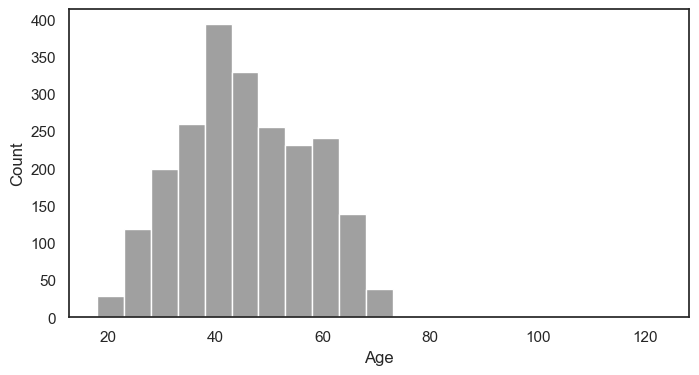

In [231]:
df1 = df_prep.copy()
sns.histplot(data=df1, x="Age", binwidth=5, color="grey")

Dilakukan pengelompokkan umur untuk melihat persebaran yang lebih merata. Terlihat pola histogram yang right-skewed dengan data yang bernilai ekstrem berada di sebelah kanan.

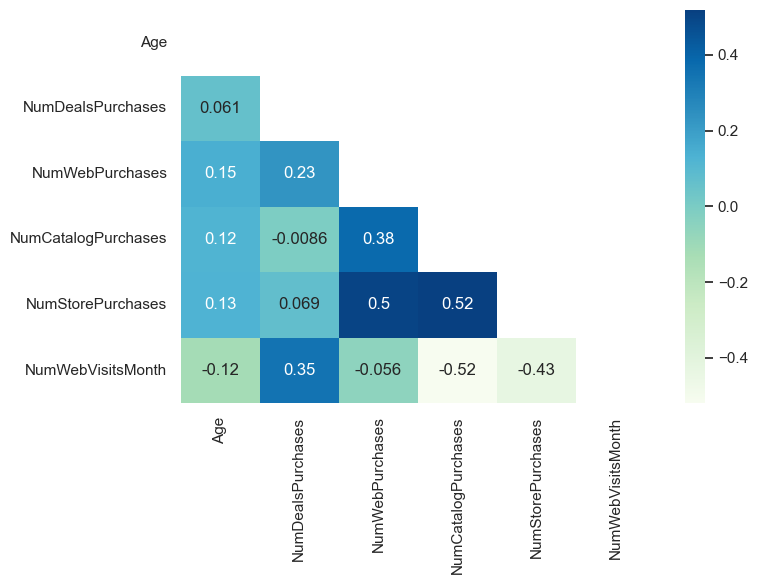

In [232]:
sns.set_theme(style="white")

corr = df[['Age', 'NumDealsPurchases','NumWebPurchases', 'NumCatalogPurchases', 'NumStorePurchases','NumWebVisitsMonth']].corr()

mask = np.triu(np.ones_like(corr, dtype=bool))
f, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(corr, mask=mask, cmap='GnBu',  annot=True)
plt.tight_layout()
plt.show()

In [233]:
bins = list(range(15, 71, 5)) + [df1['Age'].max() + 1]
labels = [f"{i}-{i+5}" for i in range(15, 70, 5)] + [">70"]
df1['age_group'] = pd.cut(df1['Age'], bins=bins, labels=labels, include_lowest=True, right=False)

In [234]:
df1_groupby = df1.groupby(['age_group', 'Response'])['ConversionRate'].agg(['median']).reset_index()
df1_groupby.columns = ['age_group', 'Response', 'Avg_ConversionRate']
df1_groupby.head()

,age_group,Response,Avg_ConversionRate
0,15-20,0,0.800000
1,15-20,1,2.888889
2,20-25,0,1.732143
3,20-25,1,9.000000
4,25-30,0,1.500000


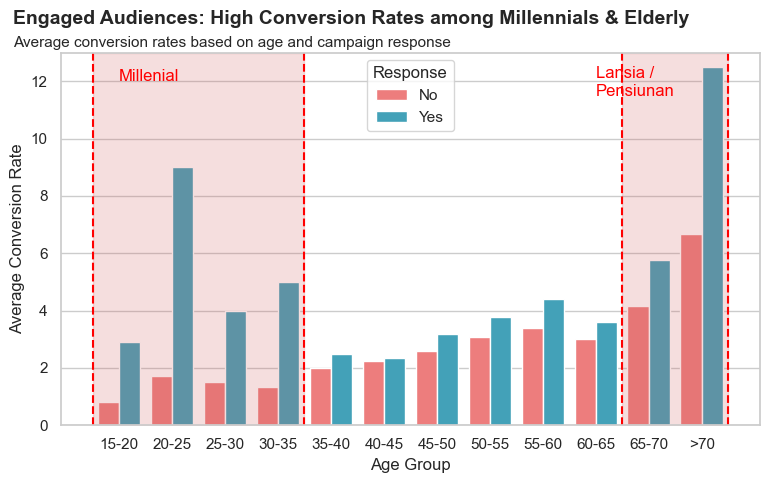

In [235]:
plt.figure(figsize=(8,5))
palette = {0: '#ff6b6b', 1: '#2fadcc'}
sns.set_theme(style="whitegrid")
g1 = sns.barplot(x='age_group', y='Avg_ConversionRate', hue='Response', data=df1_groupby, palette=palette)
labels = [item.get_text() for item in g1.get_xticklabels()]
labels = ['>70' if label == '70-75' else label for label in labels]
g1.set_xticklabels(labels)
g1.set_xlabel("Age Group", fontsize=12)
g1.set_ylabel("Average Conversion Rate", fontsize=12)

leg = g1.get_legend()
leg.texts[0].set_text("No")
leg.texts[1].set_text("Yes")

plt.axvline(3.5, ls='--', color='red') 
plt.axvline(-0.5, ls='--', color='red') 
plt.text(x=0, y=12, s='Millenial', fontsize=12, color='red', rotation=0) 
plt.stackplot(np.arange(-0.5,4.5,1), [[13]], color='indianred', alpha=0.2) 

plt.axvline(9.5, ls='--', color='red') 
plt.axvline(11.5, ls='--', color='red') 
plt.text(x=9, y=11.5, s='Lansia / \nPensiunan', fontsize=12, color='red', rotation=0) 
plt.stackplot(np.arange(9.5,12.5,1), [[13]], color='indianred', alpha=0.2) 

plt.ylim(0, 13)
plt.text(x=-2, y=14, s="Engaged Audiences: High Conversion Rates among Millennials & Elderly", fontsize=14, fontweight='bold') 
plt.text(x=-2, y=13.2, s="Average conversion rates based on age and campaign response", fontsize=11) 

plt.tight_layout()
plt.show()

- Conversion rate pada customer yang merespon campaign selalu lebih tinggi daripada customer yang tidak merespon campaign
- Terjadi peningkatan conversion rate pada kelompok usia 15-35 namun mengalami penurunan pada usia 35 dan kembali meningkat hingga usia 70 tahun keatas
- Tingginya conversion rate pada usia milenial yaitu 15-35 pada customer yang merespon campaign dapat disebabkan oleh kecenderungan penggunaan teknologi sehingga membuat kelompok ini lebih mudah dijangkau oleh campaign dan lebih mungkin untuk merespons melalui pembelian. Melalui heat map diketahui bahwa umur dan pembelian melalui website maupun catalog memiliki hubungan yang positif sehingga pada kelompok usia 15-35 lebih nyaman berbelanja online, yang bisa meningkatkan tingkat konversi.
- Conversion rate yang tinggi juga terjadi customer dengan 65 tahun ke atas, pada umumnya kelompok ini didominasi oleh pensiunan yang memiliki banyak waktu luang untuk merespon campaign hingga akhirnya melakukan pembelian. Disamping itu, kelompok usia 65 tahun ketas diduga memiliki finansial yang cenderung stabil sehingga memiliki lebih banyak sumber daya untuk membelanjakan produk atau layanan yang mereka inginkan

<Axes: xlabel='TotalSpent', ylabel='Count'>

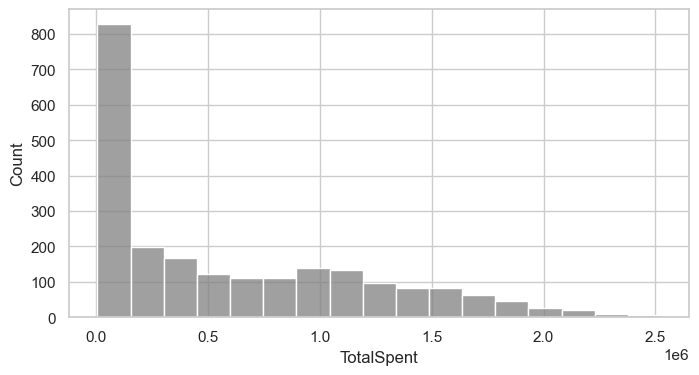

In [236]:
df2 = df_prep.copy()
sns.histplot(data=df2, x="TotalSpent", color="grey")

In [237]:
df2['TotalSpent'] = df2['TotalSpent']/100000
#df2['TotalSpent'] = np.where(df2['TotalSpent'] > 20, 21, df2['TotalSpent'])
bins = list(np.arange(0,max(df2['TotalSpent'])+2, 2))
labels = ["{0}-{1}".format(str(bins[x]), str(bins[x+1])) for x in range(len(bins[:-1]))]
df2['total_spent_group'] = pd.cut(df2['TotalSpent'],bins=bins, include_lowest=True, labels=labels)

In [238]:
df2_groupby = df2.groupby(['total_spent_group', 'Response'])['ConversionRate'].agg(['median']).reset_index()
df2_groupby.columns = ['total_spent_group', 'Response', 'Avg_ConversionRate']
df2_groupby.head()

,total_spent_group,Response,Avg_ConversionRate
0,0.0-2.0,0,1.055556
1,0.0-2.0,1,1.000000
2,2.0-4.0,0,2.400000
3,2.0-4.0,1,2.055556
4,4.0-6.0,0,3.166667


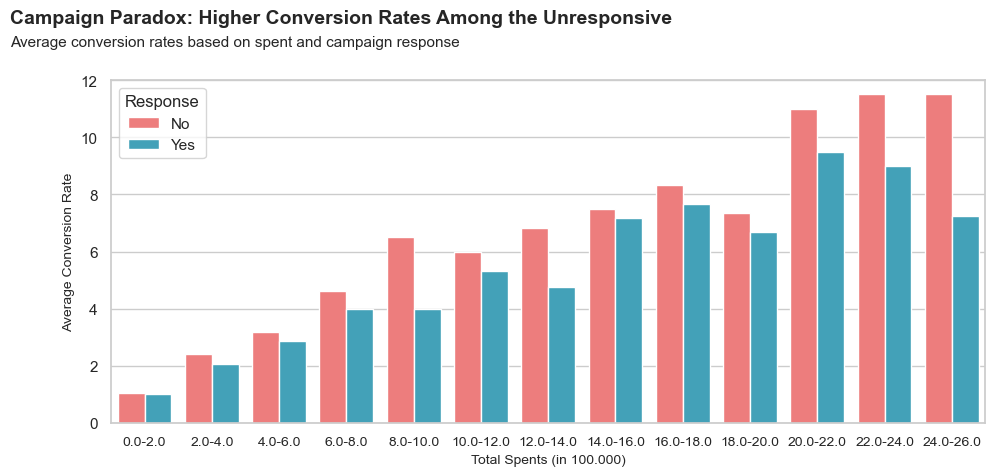

In [239]:
plt.figure(figsize=(10,5))
palette = {0: '#ff6b6b', 1: '#2fadcc'}
sns.set_theme(style="whitegrid")
g1 = sns.barplot(x='total_spent_group', y='Avg_ConversionRate', hue='Response', data=df2_groupby, palette=palette)
plt.xticks(fontsize=10)
plt.xlabel("Total Spents (in 100.000)", fontsize=10) 
plt.ylabel("Average Conversion Rate", fontsize=10)

leg = g1.get_legend()
leg.texts[0].set_text("No")
leg.texts[1].set_text("Yes")

plt.ylim(0, 12)
plt.text(x=-2, y=14, s="Campaign Paradox: Higher Conversion Rates Among the Unresponsive", fontsize=14, fontweight='bold') 
plt.text(x=-2, y=13.2, s="Average conversion rates based on spent and campaign response", fontsize=11) 

plt.tight_layout()
plt.show()

- Untuk semua kategori pengeluaran, rata-rata tingkat konversi pelanggan yang tidak merespons campaign selalu lebih tinggi dibandingkan dengan mereka yang merespon. Hal ini cukup tidak biasa karena diharapkan tingkat konversi yang lebih tinggi dari pelanggan yang merespons campaign. Mungkin ada faktor lain yang mempengaruhi ini atau bisa juga karena campaign tidak efektif dalam meningkatkan konversi.
- Untuk pelanggan yang merespons dan tidak merespons, terlihat bahwa tingkat konversi umumnya meningkat seiring dengan kenaikan pengeluaran. Artinya, semakin banyak pelanggan menghabiskan uang, semakin besar kemungkinan mereka untuk dikonversi.
- Meskipun tingkat konversi lebih tinggi pada pelanggan yang tidak merespons campaign, peningkatan tingkat konversi tampak lebih stabil pada pelanggan yang merespons campaign. Misalnya, pada grup pengeluaran 0 sampai 200.000, tingkat konversi mereka adalah 1.0, dan ini meningkat menjadi 2.875 pada grup 400.000-600.000, dan mencapai puncaknya menjadi 9.5 pada grup 2.000.000-2.200.000.

In [240]:
df3 = df_prep.copy()
df3['Income'] = df3['Income']/1000000

(0.0, 200.0)

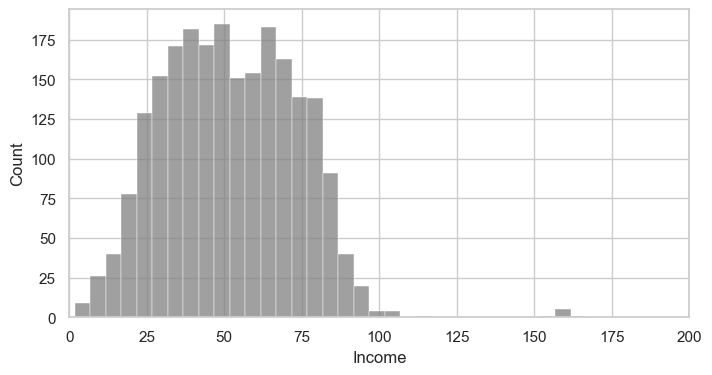

In [241]:
sns.histplot(data=df3, x="Income", binwidth=5, color="grey")
plt.xlim([0, 200])

In [242]:
# Membuat batas untuk interval
bins = list(range(0, 101, 5)) + [df3['Income'].max()]

# Membuat label untuk interval
labels = [f"{i}-{i+5}" for i in range(0, 100, 5)]
labels.append(">100")

# Mengubah 'income' menjadi fitur kategorikal
df3['income_group'] = pd.cut(df3['Income'], bins=bins, labels=labels, include_lowest=True)
df3['income_group'] = np.where(df3['income_group'] == "0-5", "5-10", df3['income_group'] )

# Mengelompokkan data berdasarkan 'income_group' dan 'Response', dan menghitung rata-rata 'ConversionRate' untuk setiap grup
df3_groupby = df3.groupby(['income_group', 'Response'])['ConversionRate'].agg(['median']).reset_index()
df3_groupby.columns = ['income_group', 'Response', 'Avg_ConversionRate']

df3_groupby = df3_groupby.replace({'income_group' : {'5-10' : '05-10'}})

# Mengurutkan data berdasarkan 'income_group' dalam urutan menurun
df3_groupby_sorted = df3_groupby.sort_values(by=['income_group', 'Response'], ascending=True)
df3_groupby_sorted = df3_groupby_sorted.replace({'income_group' : {'05-10' : '5-10'}})
df3_groupby_sorted.head()

,income_group,Response,Avg_ConversionRate
16,5-10,0,0.769737
17,5-10,1,1.333333
0,10-15,0,1.000000
1,10-15,1,1.119048
2,15-20,0,1.000000


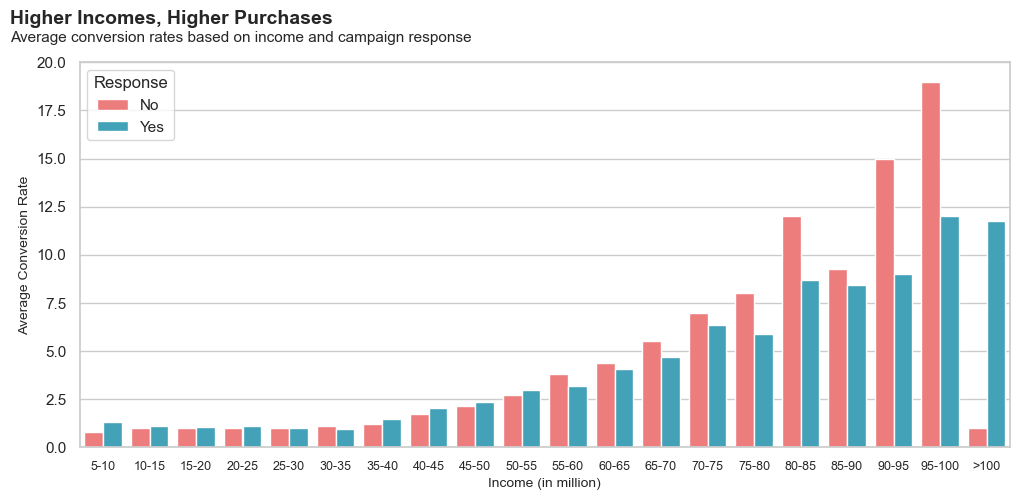

In [243]:
plt.figure(figsize=(12,5))
palette = {0: '#ff6b6b', 1: '#2fadcc'}

g1 = sns.barplot(x='income_group', y='Avg_ConversionRate', hue='Response', data=df3_groupby_sorted, palette=palette)
plt.xticks(fontsize=9)
plt.xlabel("Income (in million)", fontsize=10) 
plt.ylabel("Average Conversion Rate", fontsize=10)

plt.ylim(0, 20)
plt.text(x=-2, y=22, s="Higher Incomes, Higher Purchases", fontsize=14, fontweight='bold')
plt.text(x=-2, y=21.05, s="Average conversion rates based on income and campaign response", fontsize=11) 

leg = g1.get_legend()
leg.texts[0].set_text("No")
leg.texts[1].set_text("Yes")

plt.show()

- Tingkat konversi rata-rata umumnya cenderung naik seiring dengan peningkatan pendapatan, baik untuk pelanggan yang merespons campaign dan yang tidak. Ini mungkin menunjukkan bahwa pelanggan dengan pendapatan yang lebih tinggi lebih mungkin untuk melakukan pembelian.
- Untuk sebagian besar kelompok pendapatan, tingkat konversi rata-rata pelanggan yang merespons campaign cenderung lebih tinggi dibandingkan dengan mereka yang tidak merespons. Ini adalah hasil yang diharapkan, karena campaign dirancang untuk mendorong pembelian.
- Namun, untuk kelompok pendapatan 55 juta ke atas, tingkat konversi pelanggan yang tidak merespons campaign justru lebih tinggi. Hal ini mungkin terjadi karena pelanggan tersebut tidak memiliki banyak kebebasan untuk membuat pembelian impulsive dan lebih selektif dalam pembelian mereka.

In [244]:
main = [ 'Age', 'TotalSpent', 'Income' ]

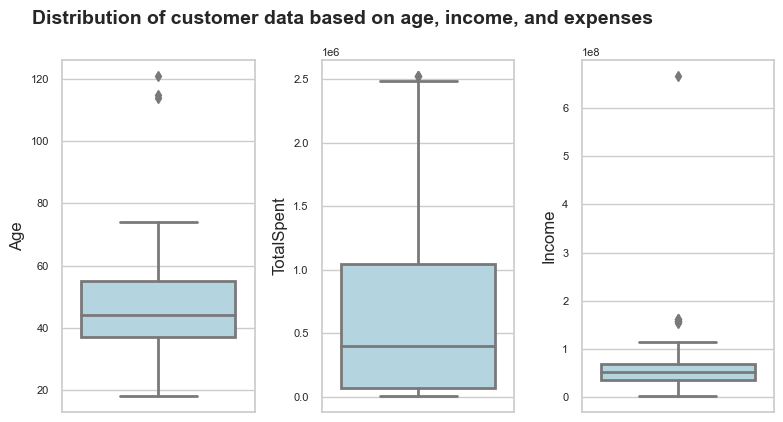

In [245]:
from matplotlib import rcParams

rcParams['figure.figsize'] = 8, 4
rcParams['lines.linewidth'] = 2
rcParams['xtick.labelsize'] = 8
rcParams['ytick.labelsize'] = 8

for i in range(0, len(main)):
    plt.subplot(1, len(main), i+1)
    sns.boxplot(y=df[main[i]], color='lightblue', orient='v')
    plt.tight_layout()

plt.suptitle("Distribution of customer data based on age, income, and expenses", x=0.05, y=1.05, fontsize=14, ha='left', fontweight='bold')
plt.show()

In [246]:
df4 = df_prep.copy()

In [247]:
df4_groupby = df4.groupby(['TotalChildren', 'Response'])['ConversionRate'].agg(['median']).reset_index()
df4_groupby.columns = ['TotalChildren', 'Response', 'Avg_ConversionRate']
df4_groupby

,TotalChildren,Response,Avg_ConversionRate
0,0,0,7.000000
1,0,1,7.000000
2,1,0,2.333333
3,1,1,2.236111
4,2,0,1.600000
5,2,1,2.000000
6,3,0,1.666667
7,3,1,3.500000


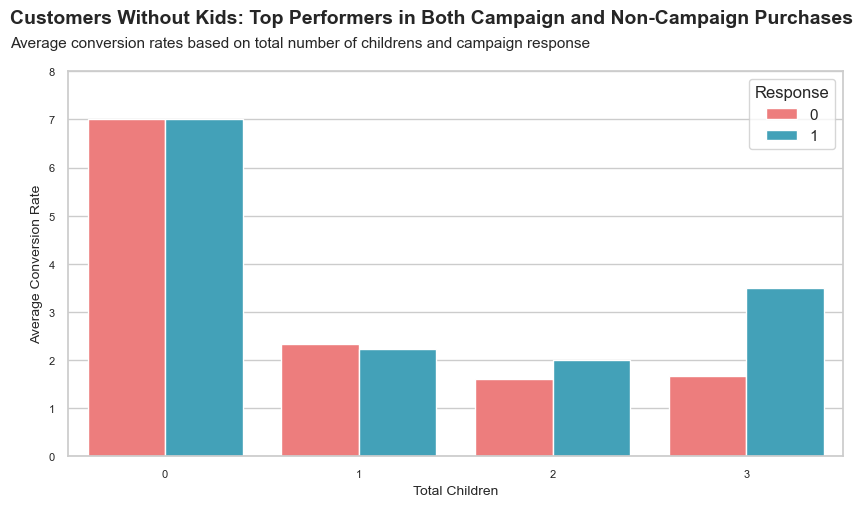

In [248]:
plt.figure(figsize=(10,5))
palette = {0: '#ff6b6b', 1: '#2fadcc'}
sns.barplot(x='TotalChildren', y='Avg_ConversionRate', hue='Response', data=df4_groupby, palette=palette)
#plt.xticks(fontsize=8)
plt.xlabel("Total Children", fontsize=10) 

plt.ylabel("Average Conversion Rate", fontsize=10) 
plt.ylim(0, 8)
plt.text(x=-0.8, y=9, s="Customers Without Kids: Top Performers in Both Campaign and Non-Campaign Purchases", fontsize=14, fontweight='bold')
plt.text(x=-0.8, y=8.5, s="Average conversion rates based on total number of childrens and campaign response", fontsize=11) 

leg = g1.get_legend()
leg.texts[0].set_text("No")
leg.texts[1].set_text("Yes")

plt.show()

- Pelanggan tanpa anak memiliki tingkat konversi yang sama (7.0) baik untuk yang merespons maupun yang tidak merespons campaign. Ini bisa menunjukkan bahwa keputusan pembelian mereka mungkin kurang dipengaruhi oleh campaign, atau bisa juga menunjukkan bahwa kampanye tersebut sama efektifnya pada grup ini, terlepas dari apakah mereka secara aktif merespons atau tidak.
- Untuk pelanggan dengan 2 anak atau lebih, tingkat konversi mereka lebih tinggi jika mereka merespons campaign, dibandingkan dengan mereka yang tidak merespons. Ini menunjukkan bahwa campaign memiliki efek positif pada keputusan pembelian grup ini.
- Secara umum, tampaknya kampanye pemasaran dapat mempengaruhi tingkat konversi, tetapi tingkat pengaruhnya bervariasi tergantung pada jumlah anak yang dimiliki pelanggan. 

In [249]:
df42_groupby = df4.groupby(['TotalCampaign', 'Response'])['ConversionRate'].agg(['median']).reset_index()
df42_groupby.columns = ['TotalCampaign', 'Response', 'Avg_ConversionRate']
df42_groupby.head()

,TotalCampaign,Response,Avg_ConversionRate
0,0,0,2.142857
1,0,1,2.500000
2,1,0,3.775000
3,1,1,3.600000
4,2,0,5.666667


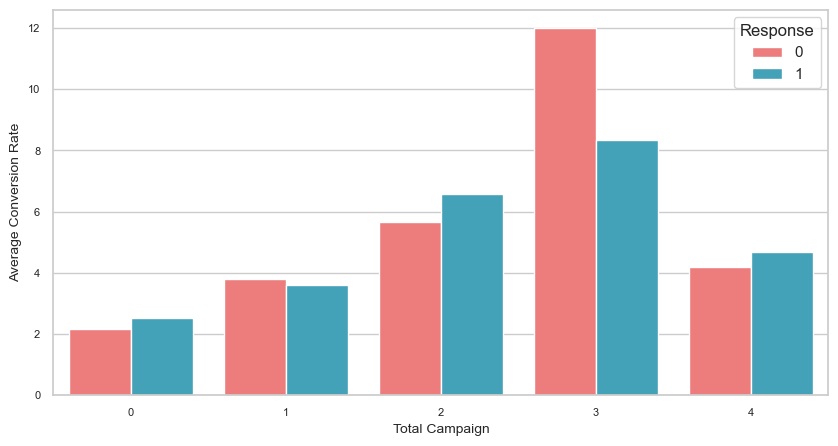

In [250]:
plt.figure(figsize=(10,5))
palette = {0: '#ff6b6b', 1: '#2fadcc'}
sns.barplot(x='TotalCampaign', y='Avg_ConversionRate', hue='Response', data=df42_groupby, palette=palette)
#plt.xticks(fontsize=8)
plt.xlabel("Total Campaign", fontsize=10) 
plt.ylabel("Average Conversion Rate", fontsize=10) 
plt.show()

In [251]:
df43_groupby = df4.groupby(['Education', 'Response'])['ConversionRate'].agg(['median']).reset_index()
df43_groupby.columns = ['Education', 'Response', 'Avg_ConversionRate']
df43_groupby.head()

,Education,Response,Avg_ConversionRate
0,D3,0,1.875000
1,D3,1,3.528571
2,S1,0,2.571429
3,S1,1,3.690476
4,S2,0,2.666667


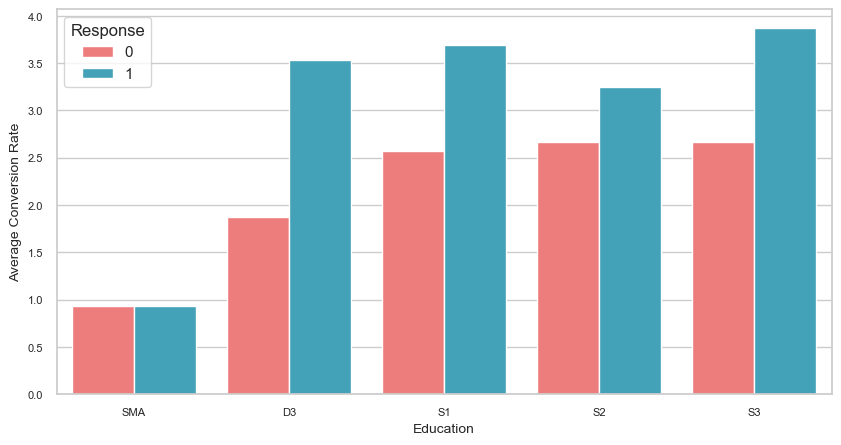

In [252]:
plt.figure(figsize=(10,5))
order = ['SMA','D3', 'S1','S2', 'S3']
palette = {0: '#ff6b6b', 1: '#2fadcc'}
sns.barplot(x='Education', y='Avg_ConversionRate', hue='Response', data=df43_groupby, order=order, palette=palette)
#plt.xticks(fontsize=8)
plt.xlabel("Education", fontsize=10) 
plt.ylabel("Average Conversion Rate", fontsize=10) 
plt.show()

In [253]:
df44_groupby = df4.groupby(['Marital_Status', 'Response'])['ConversionRate'].agg(['median']).reset_index()
df44_groupby.columns = ['Marital_Status', 'Response', 'Avg_ConversionRate']
df44_groupby.head()

,Marital_Status,Response,Avg_ConversionRate
0,Bertunangan,0,2.472222
1,Bertunangan,1,3.250000
2,Cerai,0,2.366667
3,Cerai,1,4.000000
4,Duda,0,2.354167


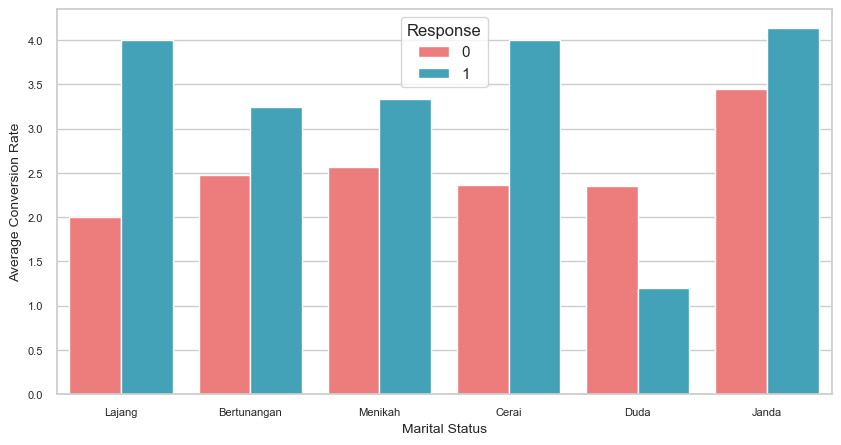

In [254]:
plt.figure(figsize=(10,5))
order = ['Lajang','Bertunangan','Menikah', 'Cerai','Duda', 'Janda']
palette = {0: '#ff6b6b', 1: '#2fadcc'}
sns.barplot(x='Marital_Status', y='Avg_ConversionRate', hue='Response', data=df44_groupby, order=order, palette=palette)
#plt.xticks(fontsize=8)
plt.xlabel("Marital Status", fontsize=10) 
plt.ylabel("Average Conversion Rate", fontsize=10) 
plt.show()

In [255]:
df5_groupby = df4.groupby(['IsParent', 'Response'])['ConversionRate'].agg(['median']).reset_index()
df5_groupby.columns = ['IsParent', 'Response', 'Avg_ConversionRate']
df5_groupby

,IsParent,Response,Avg_ConversionRate
0,0,0,7.000
1,0,1,7.000
2,1,0,2.000
3,1,1,2.125


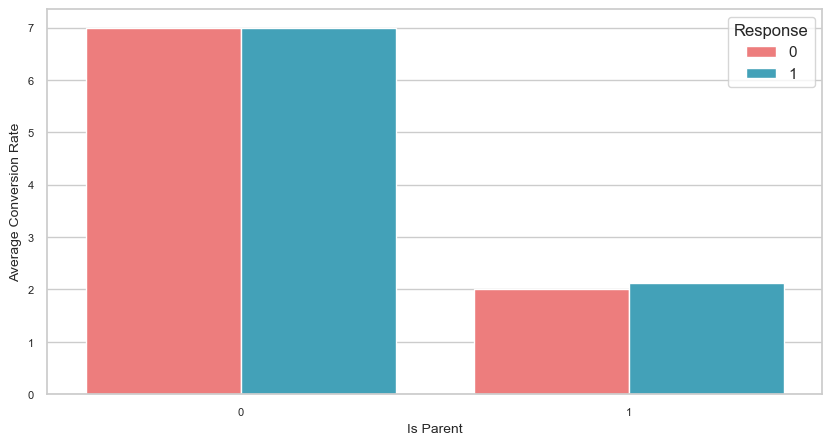

In [256]:
plt.figure(figsize=(10,5))
palette = {0: '#ff6b6b', 1: '#2fadcc'}
sns.barplot(x='IsParent', y='Avg_ConversionRate', hue='Response', data=df5_groupby, palette=palette)
#plt.xticks(fontsize=8)
plt.xlabel("Is Parent", fontsize=10) 
plt.ylabel("Average Conversion Rate", fontsize=10) 
plt.show()

In [257]:
df5 = df_prep.copy()

<Axes: xlabel='Recency', ylabel='Count'>

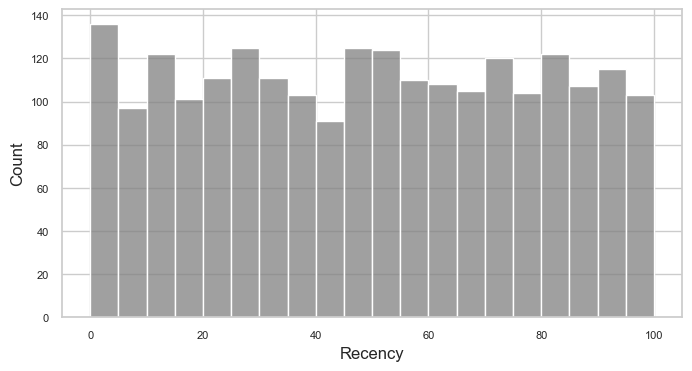

In [258]:
sns.histplot(data=df5, x="Recency", binwidth=5, color="grey")

In [259]:
bins = list(np.arange(0,max(df5['Recency'])+10, 10))
labels = ["{0}-{1}".format(str(bins[x]), str(bins[x+1])) for x in range(len(bins[:-1]))]
df5['Recency_group'] = pd.cut(df5['Recency'],bins=bins, include_lowest=True, labels=labels)

In [260]:
print(df5['Recency_group'].value_counts())

0-10      259
20-30     247
50-60     234
70-80     234
80-90     221
10-20     218
40-50     213
60-70     209
30-40     207
90-100    198
Name: Recency_group, dtype: int64


In [261]:
df5_groupby = df5.groupby(['Recency_group', 'Response'])['ConversionRate'].agg(['median']).reset_index()
df5_groupby.columns = ['Recency_group', 'Response', 'Avg_ConversionRate']
df5_groupby.head()

,Recency_group,Response,Avg_ConversionRate
0,0-10,0,2.571429
1,0-10,1,3.062500
2,10-20,0,2.000000
3,10-20,1,3.645833
4,20-30,0,2.690476


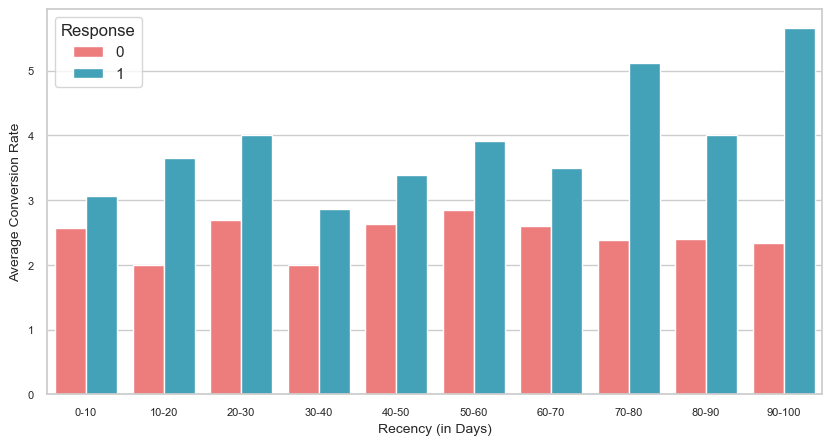

In [262]:
plt.figure(figsize=(10,5))
palette = {0: '#ff6b6b', 1: '#2fadcc'}
sns.barplot(x='Recency_group', y='Avg_ConversionRate', hue='Response', data=df5_groupby, palette=palette)
#plt.xticks(fontsize=8)
plt.xlabel("Recency (in Days)", fontsize=10) 
plt.ylabel("Average Conversion Rate", fontsize=10) 
plt.show()

In [263]:
df6 = df_prep.copy()

<Axes: xlabel='CustomerDays', ylabel='Count'>

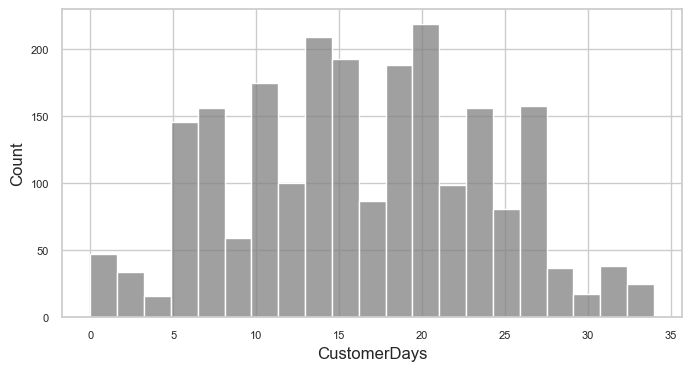

In [264]:
sns.histplot(data=df6, x="CustomerDays", color="grey")

In [265]:
bins = list(np.arange(0,max(df6['CustomerDays'])+2, 2))
labels = ["{0}-{1}".format(str(bins[x]), str(bins[x+1])) for x in range(len(bins[:-1]))]
df6['CustomerDays_group'] = pd.cut(df6['CustomerDays'],bins=bins, include_lowest=True, labels=labels)

In [266]:
df6_groupby = df6.groupby(['CustomerDays_group', 'Response'])['ConversionRate'].agg(['median']).reset_index()
df6_groupby.columns = ['CustomerDays_group', 'Response', 'Avg_ConversionRate']
df6_groupby.head()

,CustomerDays_group,Response,Avg_ConversionRate
0,0-2,0,2.400000
1,0-2,1,6.062500
2,2-4,0,1.500000
3,2-4,1,10.571429
4,4-6,0,2.666667


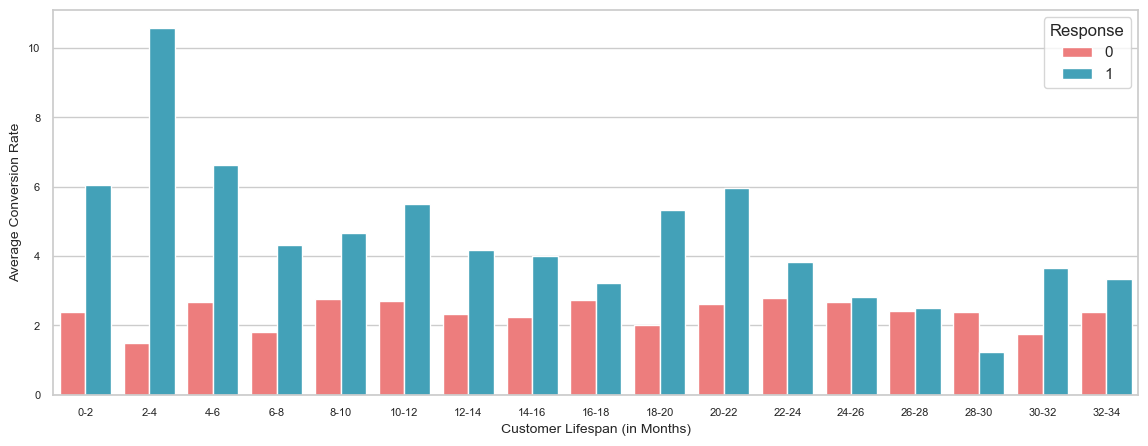

In [267]:
plt.figure(figsize=(14,5))
palette = {0: '#ff6b6b', 1: '#2fadcc'}
sns.barplot(x='CustomerDays_group', y='Avg_ConversionRate', hue='Response', data=df6_groupby, palette=palette)
#plt.xticks(fontsize=8)
plt.xlabel("Customer Lifespan (in Months)", fontsize=10) 
plt.ylabel("Average Conversion Rate", fontsize=10) 
plt.show()

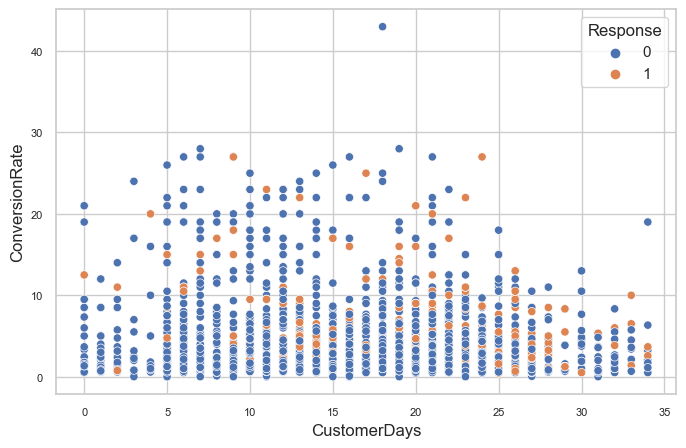

In [268]:
plt.figure(figsize=(8,5))
sns.scatterplot(x='CustomerDays', y='ConversionRate', hue='Response', data=df6)
plt.show()

In [269]:
df7 = df_prep.copy()

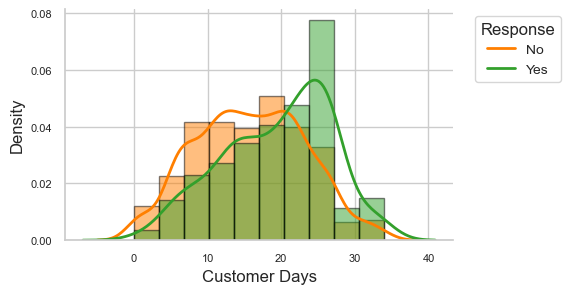

In [270]:
green_join = df7[(df7['Response']==0)]
green_join = green_join['CustomerDays']

orange_join = df7[(df7['Response']==1)]
orange_join = orange_join['CustomerDays']

fig, ax = plt.subplots(figsize=(5,3))
sns.set(style="whitegrid")
sns.distplot(green_join, hist=True, kde=True, hist_kws={'edgecolor':'black', 'alpha':0.5}, kde_kws={'linewidth':2}, bins=10, color='#ff7f00')
sns.distplot(orange_join, hist=True, kde=True, hist_kws={'edgecolor':'black', 'alpha':0.5}, kde_kws={'linewidth':2}, bins=10, color='#33a02c')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.xlabel('Customer Days')
#plt.ylim(0, 0.003)
plt.legend(labels = ["No", "Yes"], fontsize = 10, title = "Response", bbox_to_anchor=(1.04, 1), loc="upper left")
plt.show()

# Clustering

In [271]:
# feature encoding pada education dan marital status
# label encoder pada Education
df_clust = df_prep.copy()
df_clust['Education'] = df_clust['Education'].astype('category').cat.codes

# one hot encoding pada marital status karena tidak memiliki urutan
status_df_clust = pd.get_dummies(df_clust['Marital_Status'], prefix='Status')
df_clust = df_clust.join(status_df_clust)

#making function to replace outlier
def outlier (x):
    sorted(x)
    q1, q3 = x.quantile([0.25, 0.75])
    IQR = q3 - q1
    lwr_bound = q1 - (1.5*IQR)
    upr_bound = q3 + (1.5*IQR)
    return lwr_bound, upr_bound

low, high = outlier(df_clust['Income'])
low2, high2 = outlier(df_clust['Age'])
low3, high3 = outlier(df_clust['TotalSpent'])

In [272]:
df_clust = df_clust[['Recency','NumPurchase','TotalSpent']]
df_clust.head()

,Recency,NumPurchase,TotalSpent
0,58,25,1617000
1,38,6,27000
2,26,21,776000
3,26,8,53000
4,94,19,422000


In [273]:
nums = ['Recency','NumPurchase','TotalSpent']

In [274]:
scale_df_clust = df_clust.copy()
from sklearn.preprocessing import StandardScaler
ss = StandardScaler()

for n in nums:
  scaler = ss.fit(scale_df_clust[[n]])
  scale_df_clust[n] = scaler.transform(scale_df_clust[[n]])

WCSS difference between 2 and 3 clusters: 965.716818681637
WCSS difference between 3 and 4 clusters: 710.959167454519
WCSS difference between 4 and 5 clusters: 297.1499616002243
WCSS difference between 5 and 6 clusters: 215.8360182455367
WCSS difference between 6 and 7 clusters: 153.2471292523701
WCSS difference between 7 and 8 clusters: 143.12796478454447
WCSS difference between 8 and 9 clusters: 97.64282573704747
WCSS difference between 9 and 10 clusters: 77.66280018854684
WCSS difference between 10 and 11 clusters: 62.14522351624532
WCSS difference between 11 and 12 clusters: 58.80376039851819
WCSS difference between 12 and 13 clusters: 47.73099089939649
WCSS difference between 13 and 14 clusters: 37.9465496797111
WCSS difference between 14 and 15 clusters: 40.665108167273615


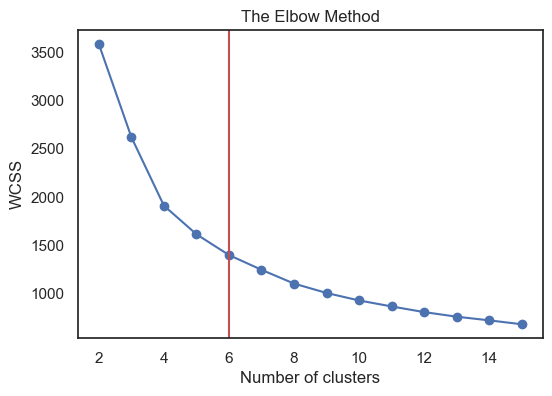

In [275]:
import sklearn
from sklearn import preprocessing
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# membuat fungsi Elbow Method
sns.set_theme('notebook', style='white')
def elbowMethod(data, k_min=2, k_max=15):
    wcss = [] # Within Cluster Sum of Squares
    diff_wcss = [] # Difference in WCSS
    k_range = range(k_min, k_max + 1)

    for i in k_range:
        kmeans_test = KMeans(n_clusters = i, random_state = 42, init = 'k-means++')
        kmeans_test.fit(data)
        wcss.append(kmeans_test.inertia_)
        
        if i != k_min:
            diff = wcss[-2] - wcss[-1]  
            diff_wcss.append(diff)
            print(f"WCSS difference between {i-1} and {i} clusters: {diff}")

    fig, ax = plt.subplots(figsize=(6,4))
    ax.plot(k_range, wcss, marker='o')

    plt.axvline(x = 6, color = 'r')
    plt.title('The Elbow Method')
    plt.xlabel('Number of clusters')
    plt.ylabel('WCSS')
    plt.show()

elbowMethod(scale_df_clust)

- Penurunan antara 7 dan 8 klaster, serta antara 8 dan 9 klaster, cukup signifikan, tapi setelah itu penurunannya tidak terlalu besar.
- Jadi, berdasarkan metode elbow, kita mungkin memilih antara 7 dan 9 sebagai jumlah klaster yang optimal. 
- Pada analisis ini dipilih jumlah klaster optimum yaitu 8 klaster

In [276]:
from sklearn.metrics import silhouette_score

for n_clusters in range(2,16):
    clusterer = KMeans(n_clusters=n_clusters,init='k-means++', random_state=1234).fit(scale_df_clust)
    preds = clusterer.predict(scale_df_clust)

    score = silhouette_score(scale_df_clust, preds, metric='mahalanobis')
    print ("For n_clusters = {}. The average silhouette_score is : {}".format(n_clusters, score))

For n_clusters = 2. The average silhouette_score is : 0.2932727136833697
For n_clusters = 3. The average silhouette_score is : 0.2688446870045716
For n_clusters = 4. The average silhouette_score is : 0.29362519478184407
For n_clusters = 5. The average silhouette_score is : 0.28941992313311043
For n_clusters = 6. The average silhouette_score is : 0.2831806777524668
For n_clusters = 7. The average silhouette_score is : 0.2502523354497907
For n_clusters = 8. The average silhouette_score is : 0.27511750802700075
For n_clusters = 9. The average silhouette_score is : 0.28485843038020375
For n_clusters = 10. The average silhouette_score is : 0.28617900461789875
For n_clusters = 11. The average silhouette_score is : 0.2873003190523439
For n_clusters = 12. The average silhouette_score is : 0.28443985435529057
For n_clusters = 13. The average silhouette_score is : 0.2854914089791005
For n_clusters = 14. The average silhouette_score is : 0.2939756849409121
For n_clusters = 15. The average silhoue

In [277]:
km = KMeans(n_clusters=6)
km.fit(scale_df_clust)
y_predicted = km.predict(scale_df_clust)
scale_df_clust['hasil_klaster'] = y_predicted

In [278]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)

pca.fit(scale_df_clust)
pcs = pca.transform(scale_df_clust)

In [279]:
data_pca = pd.DataFrame(data = pcs, columns = ['PC 1', 'PC 2'])
data_pca['cluster']  = y_predicted
data_pca.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2240 entries, 0 to 2239
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   PC 1     2240 non-null   float64
 1   PC 2     2240 non-null   float64
 2   cluster  2240 non-null   int32  
dtypes: float64(2), int32(1)
memory usage: 43.9 KB


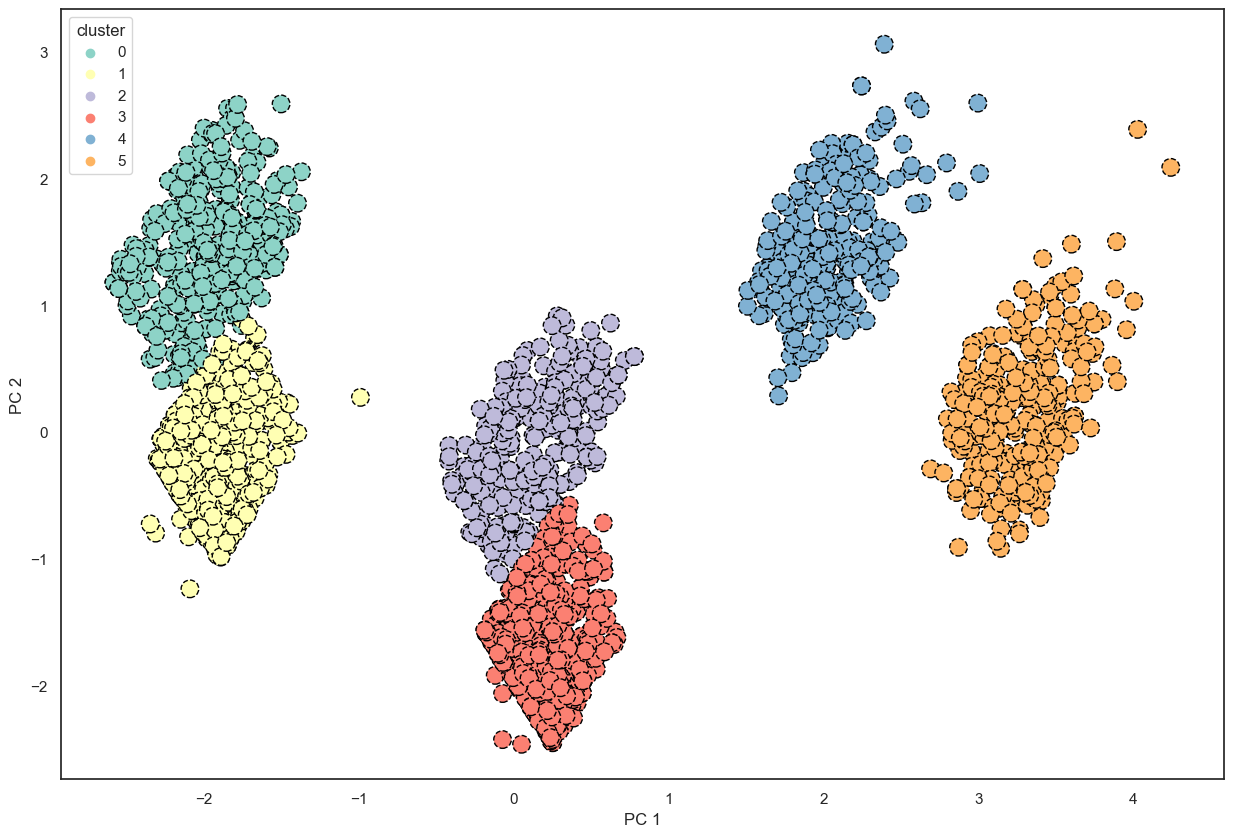

In [280]:
fig, ax = plt.subplots(figsize=(15,10))

sns.scatterplot(
    x="PC 1", y="PC 2",
    hue="cluster",
    edgecolor='black',
    linestyle='--',
    data=data_pca,
    s=160,
    ax=ax,
    palette='Set3' 
)

plt.show()

In [281]:
df_clust_result = df_clust.copy()
df_clust_result['klaster'] = y_predicted
df_clust_result.head()

,Recency,NumPurchase,TotalSpent,klaster
0,58,25,1617000,4
1,38,6,27000,3
2,26,21,776000,2
3,26,8,53000,3
4,94,19,422000,0


In [282]:
df_scaled = df_clust_result[['Recency','NumPurchase','TotalSpent']]
df_scaled.head()

,Recency,NumPurchase,TotalSpent
0,58,25,1617000
1,38,6,27000
2,26,21,776000
3,26,8,53000
4,94,19,422000


In [283]:
from sklearn.preprocessing import MinMaxScaler
df_scaled = df_clust_result[['Recency','NumPurchase','TotalSpent']]

# Membuat scaler
scaler = MinMaxScaler()

#df_scaled = df_clust_result.copy()

# Standarisasi setiap kolom
for col in df_scaled.columns:
    df_scaled[col] = scaler.fit_transform(df_scaled[col].values.reshape(-1, 1))

df_scaled['klaster'] = y_predicted
df_scaled.head()

,Recency,NumPurchase,TotalSpent,klaster
0,0.585859,0.568182,0.639683,4
1,0.383838,0.136364,0.008730,3
2,0.262626,0.477273,0.305952,2
3,0.262626,0.181818,0.019048,3
4,0.949495,0.431818,0.165476,0


In [284]:
hasilclgroup = df_scaled.groupby('klaster').agg({'Recency': 'median',
                                                 'NumPurchase' : 'median',
                                                 'TotalSpent': 'median'}).reset_index()

hasilclgroup.set_index('klaster', inplace=True)
hasilclgroup

,Recency,NumPurchase,TotalSpent
klaster,,,
0,0.691919,0.431818,0.269444
1,0.777778,0.159091,0.023810
2,0.191919,0.409091,0.219048
3,0.252525,0.159091,0.021429
4,0.752525,0.511364,0.586310
5,0.252525,0.500000,0.541865


In [285]:
hasilcl = df_clust_result[['Recency','NumPurchase','TotalSpent','klaster']]

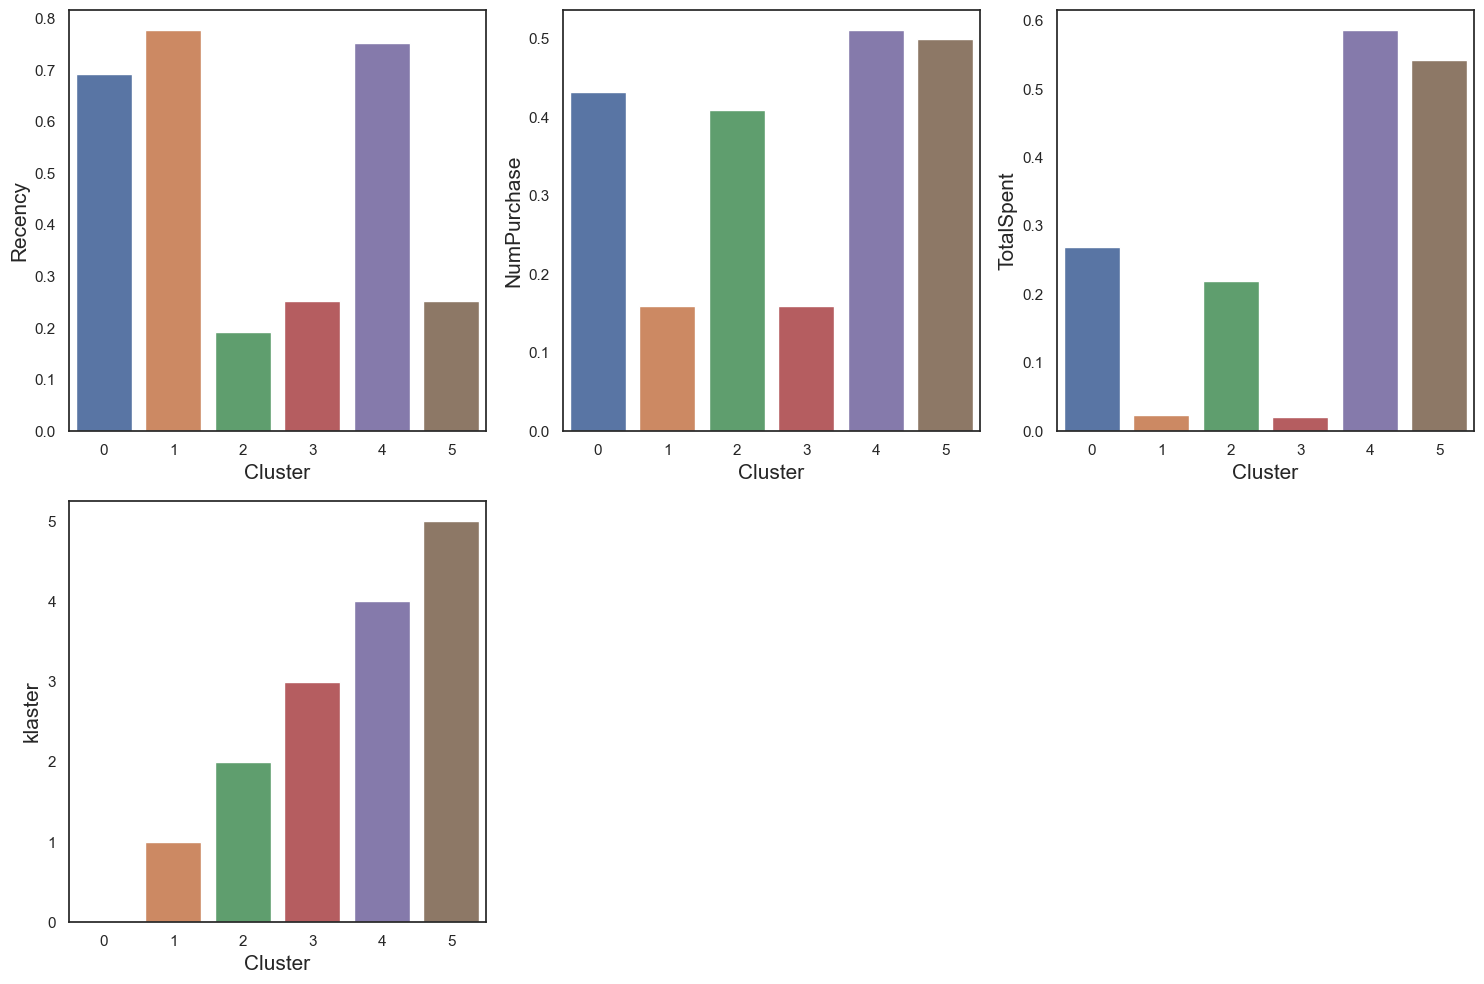

In [286]:
# grafik Visualisasi
plt.figure(figsize=(15, 10))
for i, var in enumerate(hasilcl.columns):
    plt.subplot(2, 3, i+1)
    sns.barplot(x='klaster', y=var, data=hasilclgroup.reset_index())
    plt.ylabel(var, fontsize=15)
    plt.xlabel('Cluster', fontsize=15)
plt.tight_layout()
plt.show()

In [287]:
fig = go.Figure()

# Loop over the number of clusters (0 to 7)
for i in range(6):
    fig.add_trace(
        go.Scatterpolar(
            r=hasilclgroup.loc[i].values.tolist() + hasilclgroup.loc[i].values.tolist()[:1],
            theta=hasilclgroup.columns.tolist() + hasilclgroup.columns.tolist()[:1],
            name="Cluster-%s"%i,
            showlegend=True,
        )
    )

fig.update_layout(
    polar=dict(
        radialaxis=dict(
            visible=True,
            range=[0, 1]
        )
    ),
    title="Clustering Result",
    autosize=False,
    width=800,  
    height=700
)

fig.show()

- Klaster 0: "Churning Risk" - Pelanggan dalam klaster ini memiliki risiko churn yang tinggi karena mereka belum berinteraksi atau melakukan pembelian dalam waktu yang cukup lama. Frekuensi pembelian mereka sedang, dan total pengeluaran mereka sedang. Jadi, Perusahaan harus berfokus pada strategi retensi pelanggan seperti penawaran khusus, diskon, atau program loyalitas untuk menghidupkan kembali minat mereka dalam melakukan pembelian.

- Klaster 1: "Steady Customers" - Pelanggan dalam klaster ini konsisten dalam melakukan pembelian, namun mereka melakukan pembelian dengan frekuensi yang sedang, dan total pengeluaran mereka sedang. Mereka adalah pembeli yang konsisten tetapi tidak banyak menghabiskan uang. Perusahaan dapat melakukan cross-selling produk dan layanan tambahan.

- Klaster 2: "Casual Buyers" - Pelanggan dalam klaster ini mungkin adalah pembeli kasual atau pembeli baru yang belum berbelanja dalam jumlah atau frekuensi yang tinggi. Perusahaan dapat memberikan penawaran atau diskon yang relevan dan menarik, atau mencoba untuk lebih memahami preferensi dan kebutuhan mereka.

- Klaster 3: "Inactive Customers" - Pelanggan dalam klaster ini mungkin adalah pelanggan yang tidak aktif atau telah berhenti melakukan pembelian. Perusahaan perlu melakukan pendekatan yang lebih pribadi untuk memahami alasan mereka menjadi tidak aktif dan mencoba untuk membujuk mereka untuk kembali berbelanja. Dapat dilakukan survei kepuasan pelanggan, panggilan langsung, atau email pribadi. 

- Klaster 4: "High-Value Customers" - Pelanggan dalam klaster ini sering berbelanja dan menghabiskan banyak uang. Mereka adalah pelanggan yang paling bernilai. Perusahaan harus berusaha menjaga hubungan yang baik dengan mereka, memastikan bahwa mereka merasa dihargai, dan mencoba untuk lebih memahami kebutuhan dan keinginan mereka agar dapat melayani mereka lebih baik.

- Klaster 5: "Active High Spenders" - Pelanggan dalam klaster ini baru-baru ini melakukan pembelian, melakukan pembelian dengan frekuensi yang tinggi, dan total pengeluaran mereka tinggi. Mereka adalah pelanggan yang paling aktif. Perusahaan harus berusaha mempertahankan hubungan yang baik dan memastikan bahwa mereka tetap puas. Dapat melalui layanan pelanggan yang baik, penawaran eksklusif, atau merespons umpan balik dan pertanyaan mereka dengan cepat dan efektif